# 

In [22]:
import sys, os, time
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath('../modules/'))

import healpy as h
from astropy.io import fits
import multiprocessing as mp
from cosmology import cosmo_fn
from modules.settings import global_mmf_settings as gset
from wrapper_scripts import evaluate_Y_M_scaling_reln_esz_cat as ymsr
from fitstat import fit_Y_Yx_scaling_law_bces as fitYY_bces
from fitstat import fit_Y_Yx_scaling_law_emcee as fitYY_emcee
from scipy.optimize import curve_fit
import bces.bces as bces

%pylab notebook

Populating the interactive namespace from numpy and matplotlib


# Initial setup

In [2]:
dataset="planck_pr1"
whichch="hfi"
mask_point_sources=True
numprocs=6

if whichch=="allch":
    chmin=30.
elif whichch=="hfi":
    chmin=100.
    
mask_lfi=False

use_psf_data=True
ps_suffix="_inpainted_data"
if mask_point_sources:
    use_psf_data=False
    ps_suffix="_masked_data"
    
    
figstamp=dataset + "_" + whichch + ps_suffix
dir_suffix=whichch + ps_suffix

save_results=False
run_analysis=False
figstamp,dir_suffix

('planck_pr1_hfi_masked_data', 'hfi_masked_data')

# Initialize MMF analysis

In [4]:
outpath="/results/" + dataset + "/planck_esz_cat/" + whichch + "/"
tempdatapath="/tempdata/" + dataset + "/planck_esz_cat/"
gset.setup_mmf_config(dataset="planck_pr1",outpath=outpath,tempdatapath=tempdatapath,chmin=chmin,xsize=10.,do_band_pass=True,use_psf_data=use_psf_data)
figpath=gset.mmfset.paths["result_figs"]
pmmf=ymsr.Y_M_scaling() 
xsz_cat=pmmf.xsz_cat ; pmmf.xsz_cat=ymsr.ppd.get_tangent_plane_fnames()

if mask_lfi:
    gset.mmfset.ps_mask_weights[30.]=1.
    gset.mmfset.ps_mask_weights[44.]=1.
    gset.mmfset.ps_mask_weights[70.]=1.

def wrap_eval_Y500_xray_prior(idx):
    result=pmmf.eval_Y500_xray_prior(idx)
    return result

def parallel_eval_Y500_xray_prior(numprocs):
    pool=mp.Pool(processes=numprocs)
    result=pool.map(wrap_eval_Y500_xray_prior,pmmf.idx_list)
    pool.close()
    pool.join()
    return np.array(result)

def wrap_eval_Y500_xray_prior_iterative(idx):
    result=pmmf.eval_Y500_xray_prior_iterative(idx)
    return result

def parallel_eval_Y500_xray_prior_iterative(numprocs):
    pool=mp.Pool(processes=numprocs)
    result=pool.map(wrap_eval_Y500_xray_prior_iterative,pmmf.idx_list)
    pool.close()
    pool.join()
    return np.array(result)

def wrap_eval_Y500_blind(idx):
    result=pmmf.eval_Y500_blind(idx)
    return result

def parallel_eval_Y500_blind(numprocs):
    pool=mp.Pool(processes=numprocs)
    result=pool.map(wrap_eval_Y500_blind,pmmf.idx_list)
    pool.close()
    pool.join()
    return np.array(result)

# Extract data tangent planes

In [ ]:
# ymsr.ppd.extract_tangent_planes()

## Test tangent planes and mask

Filename: /Users/adityarotti/Documents/Work/Projects/Relativistic-SZ/MMF-filters-for-rSZ-cluster-detection/Planck_MMF//tempdata/planck_pr1/planck_esz_cat/10deg_patches//tangent_planes/cluster_G321.96-47.97.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  Channels      1 ImageHDU         7   (9,)   float64   
  2  Data tangent plane    1 ImageHDU        13   (349, 349, 9)   float64   
  3  Point Source Mask    1 ImageHDU         8   (349, 349)   float64   
  4  Extended point Source Mask    1 ImageHDU         8   (349, 349)   float64   


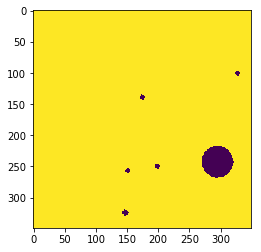

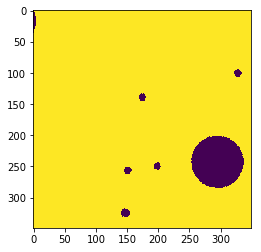

In [15]:
f=fits.open(xsz_cat["FILENAME"][61])
f.info()
figure()
imshow(f[3].data)

figure()
imshow(f[4].data)

## Inpaint sky patches.

In [5]:
# def parallel_psfill(numprocs):
#     pool=mp.Pool(processes=numprocs)
#     pool.map(ymsr.ppd.gen_ps_inpainted_data,pmmf.idx_list)
#     pool.close()
#     pool.join()
    
# start=time.time()
# parallel_psfill(numprocs)
# print time.time()-start

# Testing iterative scheme

9.53142712559e-05 8.43578684573e-06


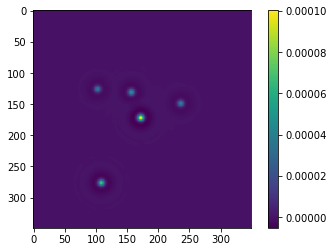

In [16]:
idx=61

pmmf.emask=ymsr.gm.return_edge_apodized_mask(15.,20.)
fdata,err,fdatar=pmmf.return_cluster_catalogue(idx)
print max((fdata*pmmf.cmask).ravel()),err

figure()
imshow(fdata-fdatar)
colorbar()

# MMF analysis with X-ray prior on location, size and temperature of cluster

In [5]:
if run_analysis:
    start=time.time()
    result=parallel_eval_Y500_xray_prior(numprocs)
    print time.time()-start

    filename="ysz_cat_xrayprior.fits"
    fxsz_cat=ymsr.write_catalogue(result,filename=filename)
else:
    filename="ysz_cat_xrayprior.fits"
    #filename="ysz_cat_xrayprior.fits"
    fxsz_cat=ymsr.read_catalogue(filename)

# Blind MMF analysis

In [6]:
if run_analysis:
    start=time.time()
    bresult=parallel_eval_Y500_blind(numprocs)
    print time.time()-start
    
    filename="ysz_cat_blind.fits"
    bxsz_cat=ymsr.write_catalogue(bresult,filename=filename)
else:
    filename="ysz_cat_blind.fits"
    bxsz_cat=ymsr.read_catalogue(filename)

# Results xray priors

## Figures for null tests

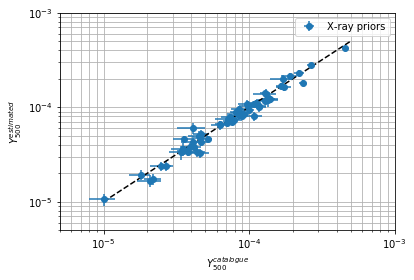

In [7]:
x=logspace(-5,-3.3,100)
figure()
lbl="X-ray priors"
errorbar(xsz_cat["YSZ_500"],fxsz_cat["YSZ_500"],xerr=xsz_cat["YSZ_500_err"],yerr=fxsz_cat["YSZ_500_err"],fmt="o",label=lbl)
lbl="Blind"
#errorbar(xsz_cat["YSZ_500"],bxsz_cat["YSZ_500"],xerr=xsz_cat["YSZ_500_err"],yerr=bxsz_cat["YSZ_500_err"],fmt="o",label=lbl)


plot(x,x,"k--")
grid(which="both")
xlabel("$Y^{catalogue}_{500}$",fontsize=10)
ylabel("$Y^{estimated}_{500}$",fontsize=10)
loglog()
ylim(5e-6,1e-3)
xlim(5e-6,1e-3)
legend(loc=0)
figname=figpath + "compare_Y500.pdf"
savefig(figname,bbox_inches="tight")

In [50]:
res=bces.return_Y_Yx_fit(fxsz_cat["YSZ_500_Tc"],fxsz_cat["YSZ_500_err_Tc"],xsz_cat["YX_500"],xsz_cat["YX_500_err"],qcut=4)#,mbias=np.ones_like(fxsz_cat["YSZ_500"]))

In [51]:
print sqrt(diag(res['cov_mat']))
print (res["param"])

[ 0.03636202  0.01198598  0.00532369]
[ 1.00899225 -3.99039431  0.0768345 ]


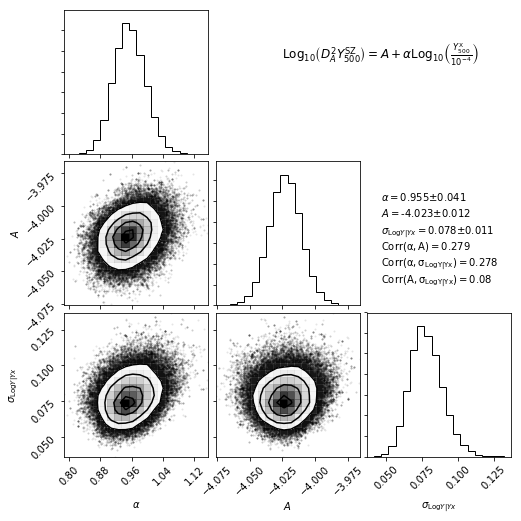

In [14]:
mbias=np.ones_like(xsz_cat["YSZ_500"])
result=fitYY_emcee.return_Y_Yx_fit(xsz_cat["YSZ_500"],xsz_cat["YSZ_500_err"],xsz_cat["YX_500"],xsz_cat["YX_500_err"],nwalkers=50,nsamples=4000,qcut=4,mbias=mbias,redshift=xsz_cat["z"])
fitYY_emcee.gen_corner_plot(result["samples"],numdec=3)
figname=figpath + "fit_ysz_yx_cat.pdf"
savefig(figname,bbox_inches="tight")

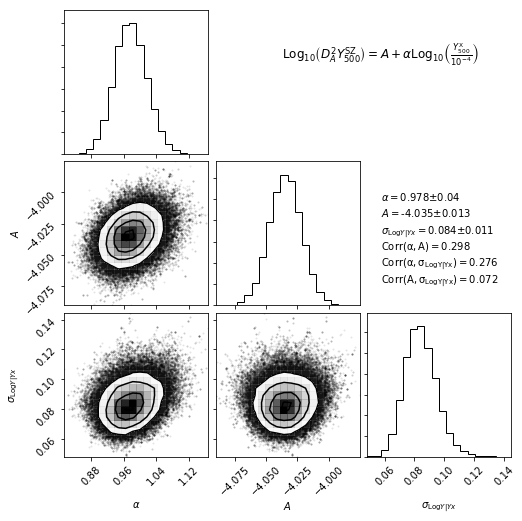

In [19]:
mbias=[] #np.ones_like(xsz_cat["YSZ_500"])
result=fitYY_emcee.return_Y_Yx_fit(fxsz_cat["YSZ_500"],fxsz_cat["YSZ_500_err"],xsz_cat["YX_500"],xsz_cat["YX_500_err"],nwalkers=50,nsamples=4000,qcut=4,mbias=mbias,redshift=xsz_cat["z"])
fitYY_emcee.gen_corner_plot(result["samples"],numdec=3)
figname=figpath + "fit_ysz_yx_T0.pdf"
savefig(figname,bbox_inches="tight")

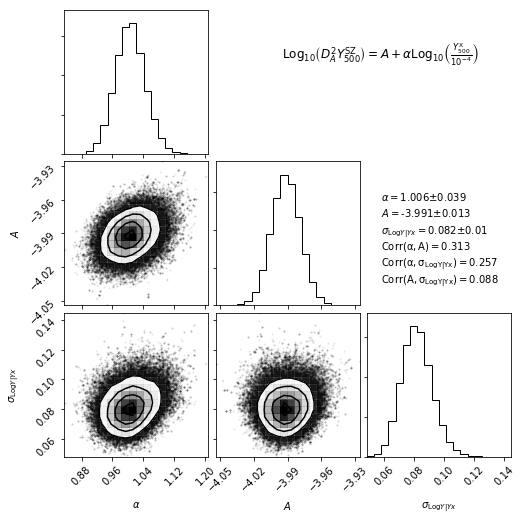

In [18]:
mbias=[] #np.ones_like(xsz_cat["YSZ_500"])
result=fitYY_emcee.return_Y_Yx_fit(fxsz_cat["YSZ_500_Tc"],fxsz_cat["YSZ_500_err_Tc"],xsz_cat["YX_500"],xsz_cat["YX_500_err"],nwalkers=50,nsamples=4000,qcut=4,mbias=mbias,redshift=xsz_cat["z"])
fitYY_emcee.gen_corner_plot(result["samples"],numdec=3)
figname=figpath + "fit_ysz_yx_Tc.pdf"
savefig(figname,bbox_inches="tight")

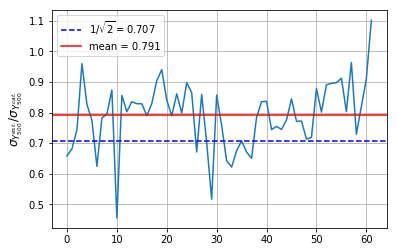

In [20]:
figure()
plot(fxsz_cat["YSZ_500_err"]/xsz_cat["YSZ_500_err"])
#axhline(1,ls="--",c="k")
axhline(1/1.414,ls="--",c="b",label="$1/\sqrt{2}=$" + str(round(1/sqrt(2.),3)))
mu=mean(np.array(fxsz_cat["YSZ_500_err"]/xsz_cat["YSZ_500_err"]))
axhline(mu,label="mean = "+ str(round(mu,3)),c="r")
legend(loc=0)
ylabel("$\sigma_{Y^{est.}_{500}}/\sigma_{Y^{cat.}_{500}}$",fontsize=12)
grid()
figname=figpath + "compare_Y500_err.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


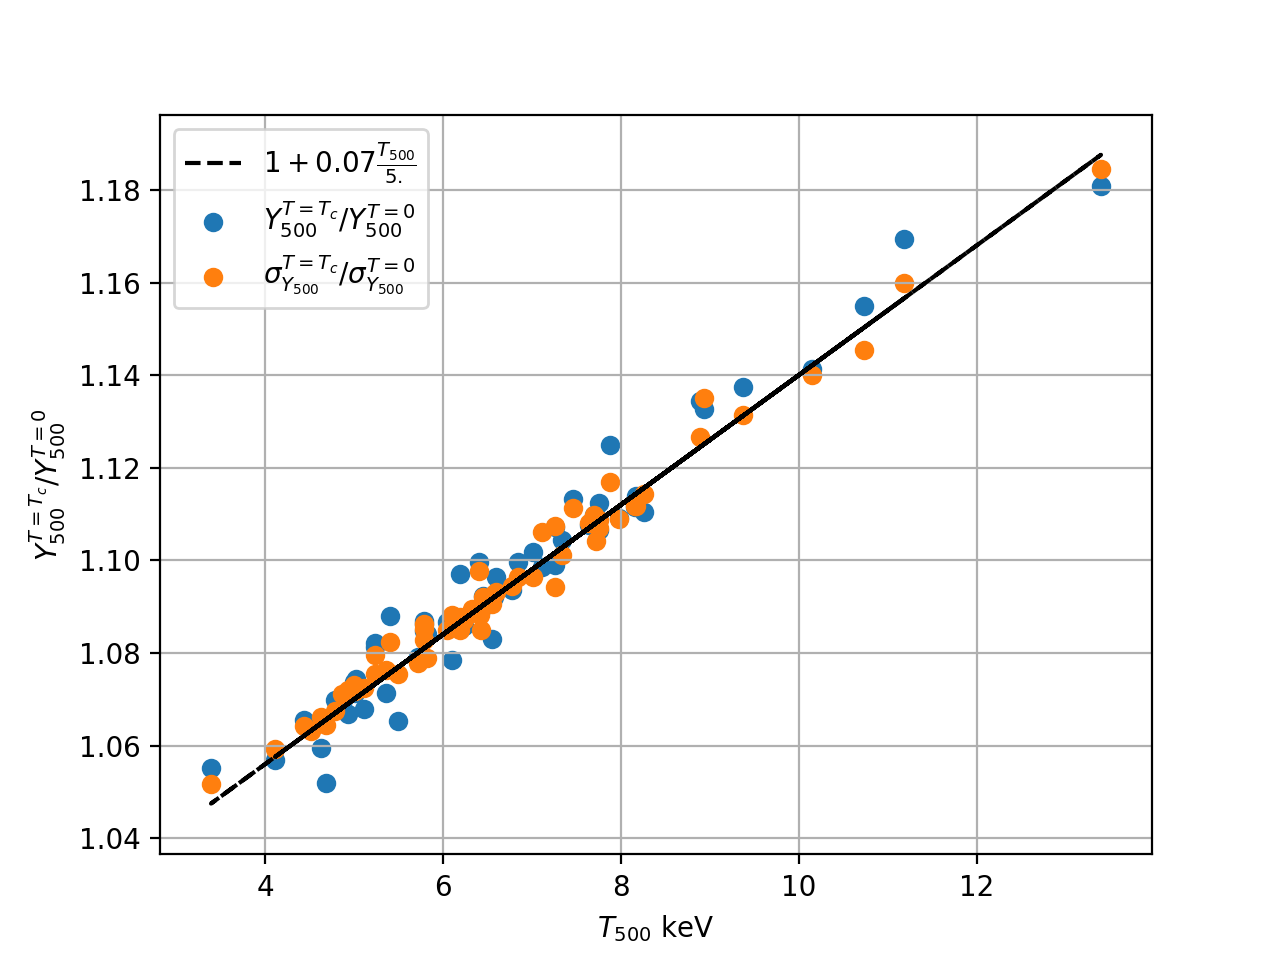

<IPython.core.display.Javascript object>


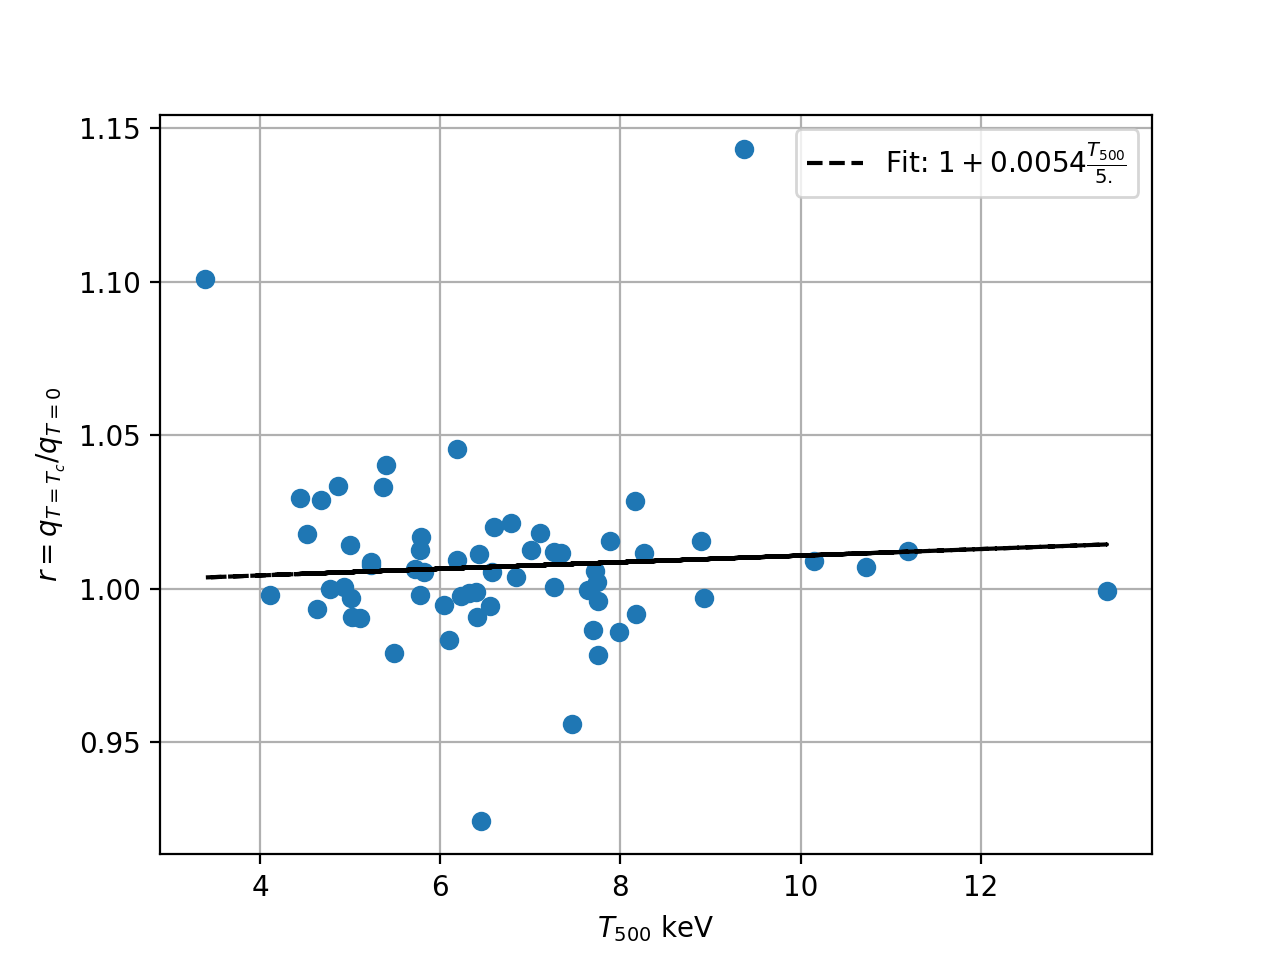

In [23]:
figure()
scatter(xsz_cat["T500"],fxsz_cat["YSZ_500_Tc"]/fxsz_cat["YSZ_500"],label="$Y^{T=T_c}_{500}/Y^{T=0}_{500}$")
scatter(xsz_cat["T500"],fxsz_cat["YSZ_500_err_Tc"]/fxsz_cat["YSZ_500_err"],label="$\sigma^{T=T_c}_{Y_{500}}/\sigma^{T=0}_{Y_{500}}$")
plot(xsz_cat["T500"],1+0.07*xsz_cat["T500"]/5.,"k--",label=r"$1 + 0.07 \frac{T_{500}}{5.}$")
xlabel('$T_{500}$ keV')
ylabel('$Y^{T=T_c}_{500}/Y^{T=0}_{500}$')
grid()
legend(loc=0)
figname=figpath + "Y500_T0_vs_Y500_Tc.pdf"
savefig(figname,bbox_inches="tight")



# Ratio of SNR
qTT=bxsz_cat["YSZ_500_Tc"]/bxsz_cat["YSZ_500_err_Tc"]
qT0=fxsz_cat["YSZ_500"]/fxsz_cat["YSZ_500_err"]

fn=lambda x,a: 1.+a*x/5.
slope,slope_err=curve_fit(fn,xsz_cat["T500"],qTT/qT0)

figure()
plot(xsz_cat["T500"],qTT/qT0,"o")
#plot(xsz_cat["T500"],1+0.07*xsz_cat["T500"]/5.,"r-",label=r"$1 + 0.07 \frac{T_{500}}{5.}$")
plot(xsz_cat["T500"],fn(xsz_cat["T500"],slope),"k--",label="Fit: " + "$1 + $" + str(round(slope,4)) + r"$\frac{T_{500}}{5.}$")
xlabel('$T_{500}$ keV')
ylabel('$r=q_{T=T_c}/q_{T=0}$')
grid()
legend(loc=0)
figname=figpath + "SNR_qT0_qTT.pdf"

## Deriving $Y^{SZ}_{500} - Y^X_{500}$ scalinng law

In [62]:
xdata=log10(xsz_cat["YX_500"]/1e-4)
xerr=return_log_err(xsz_cat["YX_500"]/1e-4,xsz_cat["YX_500_err"]/1e-4)

# Catalogue
ydata=log10(xsz_cat["YSZ_500"])
yerr=return_log_err(xsz_cat["YSZ_500"],xsz_cat["YSZ_500_err"])
acat,bcat,erracat,errbcat,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
print acat[3],erracat[3],bcat[3],errbcat[3]


# T=0
ydata=log10(fxsz_cat["YSZ_500"])
yerr=return_log_err(fxsz_cat["YSZ_500"],fxsz_cat["YSZ_500_err"])
aT0,bT0,erraT0,errbT0,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
print aT0[3],erraT0[3],bT0[3],errbT0[3]

# T=T_c
ydata=log10(fxsz_cat["YSZ_500_Tc"])
yerr=return_log_err(fxsz_cat["YSZ_500_Tc"],fxsz_cat["YSZ_500_err_Tc"])
aTT,bTT,erraTT,errbTT,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
print aTT[3],erraTT[3],bTT[3],errbTT[3]

BCES, 100000 trials... 
12.852921 s
0.958190556187 0.039501136338 -4.02406995045 0.0124118221578
BCES, 100000 trials... 
18.012716 s
0.978887839709 0.0382208453856 -4.03291426999 0.0122949784611
BCES, 100000 trials... 
12.759507 s
1.00556624392 0.0367788287828 -3.99010579601 0.0119166286293


<IPython.core.display.Javascript object>


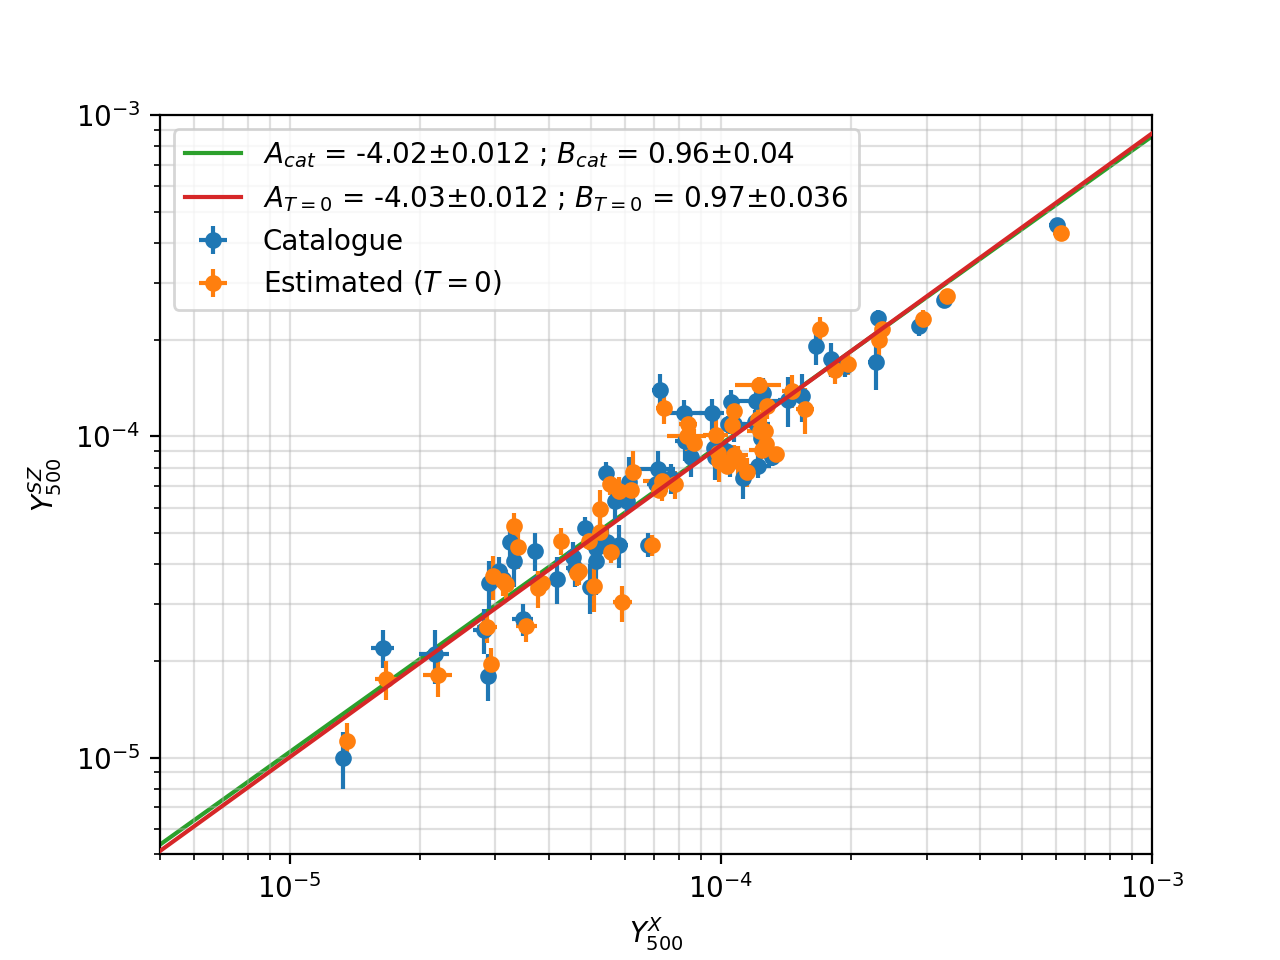

In [13]:
figure()
errorbar(xsz_cat["YX_500"],xsz_cat["YSZ_500"],xerr=xsz_cat["YX_500_err"],yerr=xsz_cat["YSZ_500_err"],fmt='o',ms=5,label="Catalogue")
errorbar(xsz_cat["YX_500"]+0.02*xsz_cat["YX_500"],fxsz_cat["YSZ_500"],xerr=xsz_cat["YX_500_err"],yerr=fxsz_cat["YSZ_500_err"],fmt='o',ms=5,label="Estimated $(T=0)$")
tempx=linspace(5e-6,5e-3,1000)
lbl="$A_{cat}$ = " + str(round(bcat[3],2)) + "$\pm$" + str(round(errbcat[3],3)) 
lbl=lbl + " ; $B_{cat}$ = " +str(round(acat[3],2))  + "$\pm$" + str(round(erracat[3],3))
plot(tempx,(10.**bcat[3])*(tempx/1e-4)**acat[3],label=lbl,zorder=1)

lbl="$A_{T=0}$ = " + str(round(bT0[3],2)) + "$\pm$" + str(round(errbT0[3],3)) 
lbl=lbl + " ; $B_{T=0}$ = " +str(round(aT0[3],2))  + "$\pm$" + str(round(erraT0[3],3))
plot(tempx,(10.**bT0[3])*(tempx/1e-4)**aT0[3],label=lbl,zorder=3)
ylim(5e-6,1e-3)
xlim(5e-6,1e-3)
loglog()
legend(loc=0)
ylabel("$Y^{SZ}_{500}$",fontsize=10)
xlabel("$Y^X_{500}$",fontsize=10)
grid(which="both",alpha=0.4)
figname=figpath + "YSZ500_YX500_cat_vs_est.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


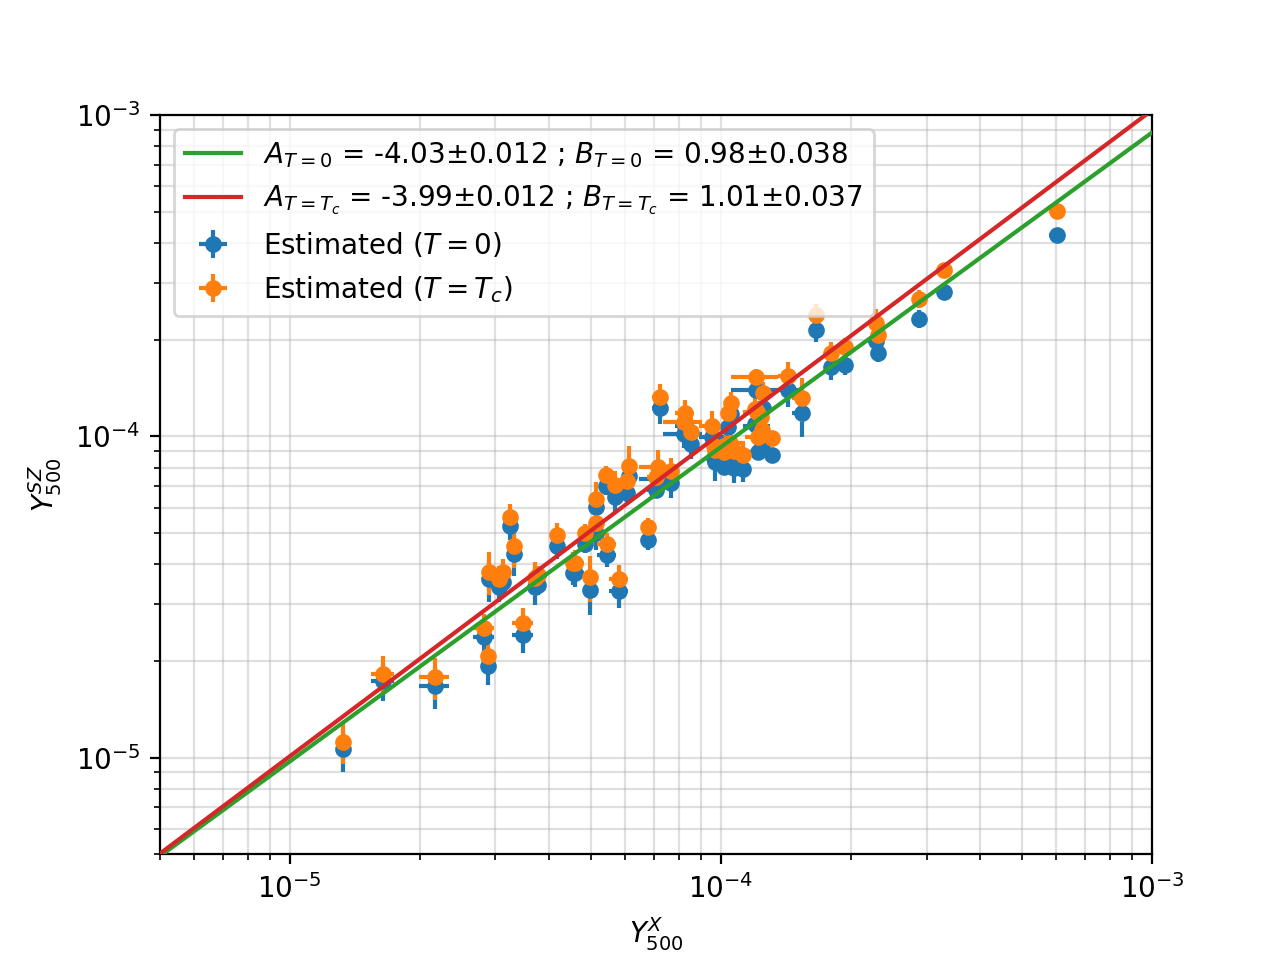

In [63]:
figure()
errorbar(xsz_cat["YX_500"],fxsz_cat["YSZ_500"],xerr=xsz_cat["YX_500_err"],yerr=fxsz_cat["YSZ_500_err"],fmt='o',ms=5,label="Estimated $(T=0)$")
errorbar(xsz_cat["YX_500"],fxsz_cat["YSZ_500_Tc"],xerr=xsz_cat["YX_500_err"],yerr=fxsz_cat["YSZ_500_err_Tc"],fmt='o',ms=5,label="Estimated $(T=T_c)$")
tempx=linspace(5e-6,5e-3,1000)
lbl="$A_{T=0}$ = " + str(round(bT0[3],2)) + "$\pm$" + str(round(errbT0[3],3)) 
lbl=lbl + " ; $B_{T=0}$ = " +str(round(aT0[3],2))  + "$\pm$" + str(round(erraT0[3],3))
plot(tempx,(10.**bT0[3])*(tempx/1e-4)**aT0[3],label=lbl,zorder=3)

lbl="$A_{T=T_c}$ = " + str(round(bTT[3],2)) + "$\pm$" + str(round(errbTT[3],3)) 
lbl=lbl + " ; $B_{T=T_c}$ = " +str(round(aTT[3],2))  + "$\pm$" + str(round(erraTT[3],3))
plot(tempx,(10.**bTT[3])*(tempx/1e-4)**aTT[3],label=lbl,zorder=5)

ylim(5e-6,1e-3)
xlim(5e-6,1e-3)
loglog()
legend(loc=0)
ylabel("$Y^{SZ}_{500}$",fontsize=10)
xlabel("$Y^X_{500}$",fontsize=10)
grid(which="both",alpha=0.4)
figname=figpath + "YSZ500_YX500_T0_vs_TT.pdf"
savefig(figname,bbox_inches="tight")

## Deriving $Y^{SZ}_{500} - M^X_{500}$ scalinng law

In [64]:
# # This produces numbers in row 2 of Table 2 from Planck early results XI (A&A 536 A11 2011)
# Ezgamma=cosmo_fn.Ez(xsz_cat["z"])**(-2./3.)
# This produces numbers in Table A.1 from Planck Collaboration: Cosmology from SZ cluster counts (2013)
Ezgamma=cosmo_fn.Ez(xsz_cat["z"])**(-2./3.)/1e-4

xdata=log10(xsz_cat["M500"]/6.)
xerr=return_log_err(xsz_cat["M500"]/6.,xsz_cat["M500_err"]/6.)

# Catalogue
ydata=log10(xsz_cat["YSZ_500"]*Ezgamma)
yerr=return_log_err(xsz_cat["YSZ_500"]*Ezgamma,xsz_cat["YSZ_500_err"]*Ezgamma)
acat,bcat,erracat,errbcat,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
print acat[3],erracat[3],bcat[3],errbcat[3]


# T=0
ydata=log10(fxsz_cat["YSZ_500"]*Ezgamma)
yerr=return_log_err(fxsz_cat["YSZ_500"]*Ezgamma,fxsz_cat["YSZ_500_err"]*Ezgamma)
aT0,bT0,erraT0,errbT0,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
print aT0[3],erraT0[3],bT0[3],errbT0[3]

# T=T_c
ydata=log10(fxsz_cat["YSZ_500_Tc"]*Ezgamma)
yerr=return_log_err(fxsz_cat["YSZ_500_Tc"]*Ezgamma,fxsz_cat["YSZ_500_err_Tc"]*Ezgamma)

aTT,bTT,erraTT,errbTT,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
print aTT[3],erraTT[3],bTT[3],errbTT[3]

BCES, 100000 trials... 
15.247166 s
1.7356662812 0.0775050328644 -0.188517464281 0.0125455228912
BCES, 100000 trials... 
14.287283 s
1.77896554557 0.0742083898416 -0.200322036286 0.0126522629881
BCES, 100000 trials... 
15.130190 s
1.8273666632 0.0705506984756 -0.161672144749 0.0124208120627


In [67]:
Ezgamma=cosmo_fn.Ez(xsz_cat["z"])**(-2./3.)/1e-4

xdata=log10(xsz_cat["M500"]/6.)
xerr=return_log_err(xsz_cat["M500"]/6.,xsz_cat["M500_err"]/6.)

# Catalogue
ydata=log10(xsz_cat["YSZ_500"]*Ezgamma)
yerr=return_log_err(xsz_cat["YSZ_500"]*Ezgamma,xsz_cat["YSZ_500_err"]*Ezgamma)
acat,bcat,erracat,errbcat,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
print acat[3],erracat[3],bcat[3],errbcat[3]

BCES, 100000 trials... 
13.001137 s
1.73538364283 0.077346212074 -0.188436470164 0.0125446966597


In [17]:
sigmai2=yerr**2. + (acat[3]*xerr)**2.
wi=1./sigmai2
N=np.size(wi)*1.
norm=np.sum(wi)/N
wi=wi/norm

datadiff2=(ydata-acat[3]*xdata-bcat[3])**2.

### Statistical

In [18]:
np.sqrt(np.sum(wi*sigmai2)/(N-2.))

0.0523364160052852

In [123]:
sqrt(sum(sigmai2)/N)

0.063845798466650283

### Raw

In [133]:
sigma_raw=np.sqrt(((1./(N-2.))*np.sum(wi*datadiff2)))
print sigma_raw

0.0893183599689


In [131]:
np.sqrt(sigma_raw**2./(N-2.))

0.011530950689007179

### Intrinsic

In [126]:
sigma_int=np.sqrt(((1./(N-2.))*np.sum(wi*datadiff2))-sum(sigmai2)/N)

In [128]:
np.sqrt(sigma_int**2./(N-3.))

0.0081318410008203862

<IPython.core.display.Javascript object>


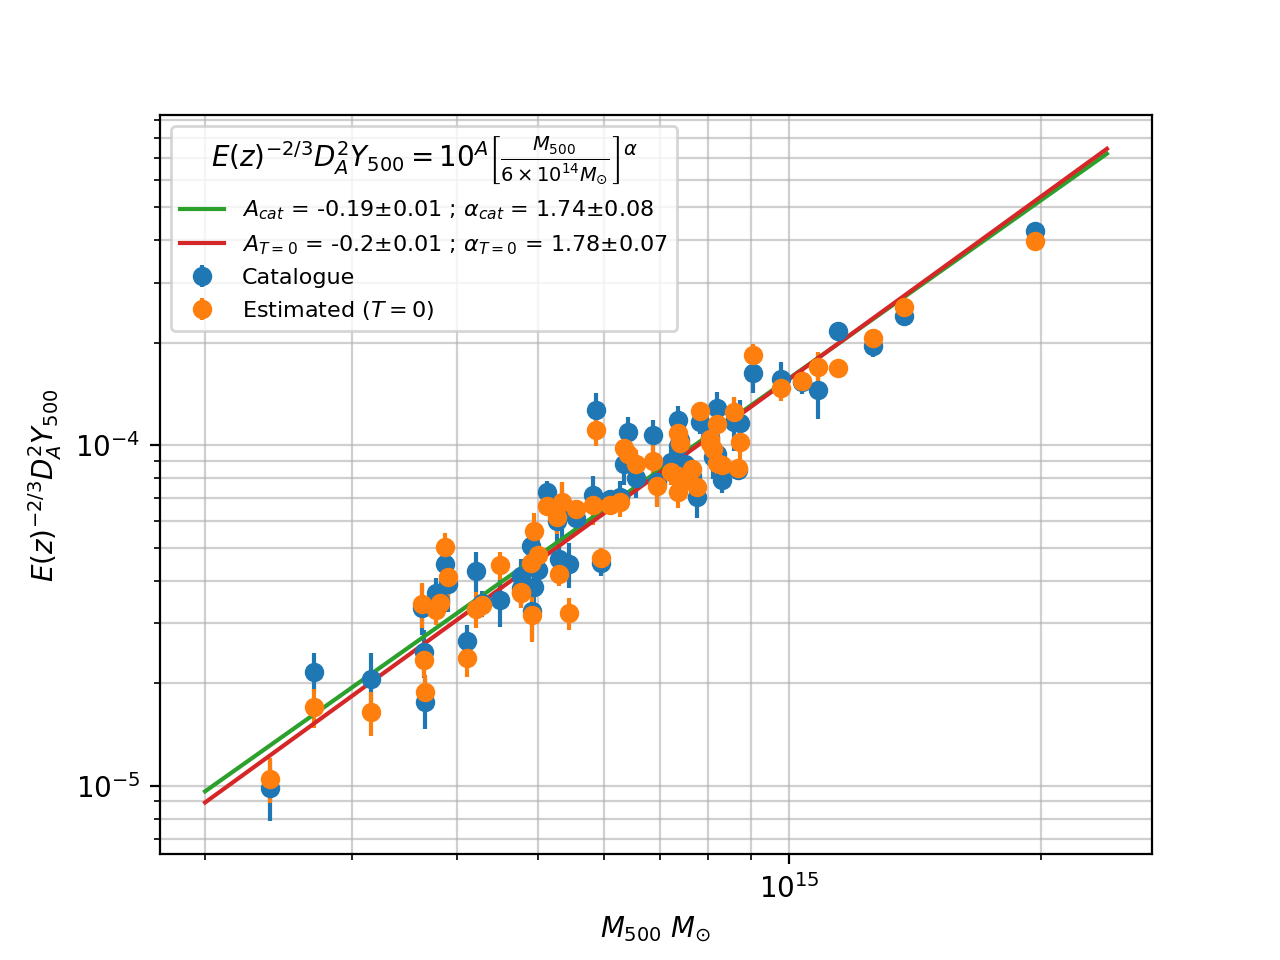

In [68]:
M500=linspace(2,24,1000)
norm=1e-4
figure()
errorbar(xsz_cat["M500"]*1e14,Ezgamma*xsz_cat["YSZ_500"]*norm,yerr=xsz_cat["YSZ_500_err"]*Ezgamma*norm,fmt="o",label="Catalogue")
errorbar(xsz_cat["M500"]*1e14,Ezgamma*fxsz_cat["YSZ_500"]*norm,yerr=fxsz_cat["YSZ_500_err"]*Ezgamma*norm,fmt="o",label="Estimated $(T=0)$")

lbl=r"$A_{cat}$ = " + str(round(bcat[3],2)) + r"$\pm$" + str(round(errbcat[3],2)) 
lbl=lbl + r" ; $\alpha_{cat}$ = " +str(round(acat[3],2))  + r"$\pm$" + str(round(erracat[3],2))
plot(M500*1e14,(10.**bcat[3])*((M500/6.)**acat[3])*norm,label=lbl)

lbl=r"$A_{T=0}$ = " + str(round(bT0[3],2)) + "$\pm$" + str(round(errbT0[3],2)) 
lbl=lbl + r" ; $\alpha_{T=0}$ = " +str(round(aT0[3],2))  + "$\pm$" + str(round(erraT0[3],2))
plot(M500*1e14,(10.**bT0[3])*((M500/6.)**aT0[3])*norm,label=lbl)

ylabel(r"$E(z)^{-2/3} D^2_A Y_{500}$")
xlabel(r"$M_{500}$" + " " + "$M_{\odot}$")
lbl=r"$E(z)^{-2/3} D^2_A Y_{500} = 10^A \left[ \frac{M_{500}}{6 \times 10^{14} M_{\odot}}\right]^\alpha$"
legend(loc=0,title=lbl,fontsize=8)
loglog()
grid(which="both",alpha=0.6)
figname=figpath + "Y500_vs_M500_compare_with_cat.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


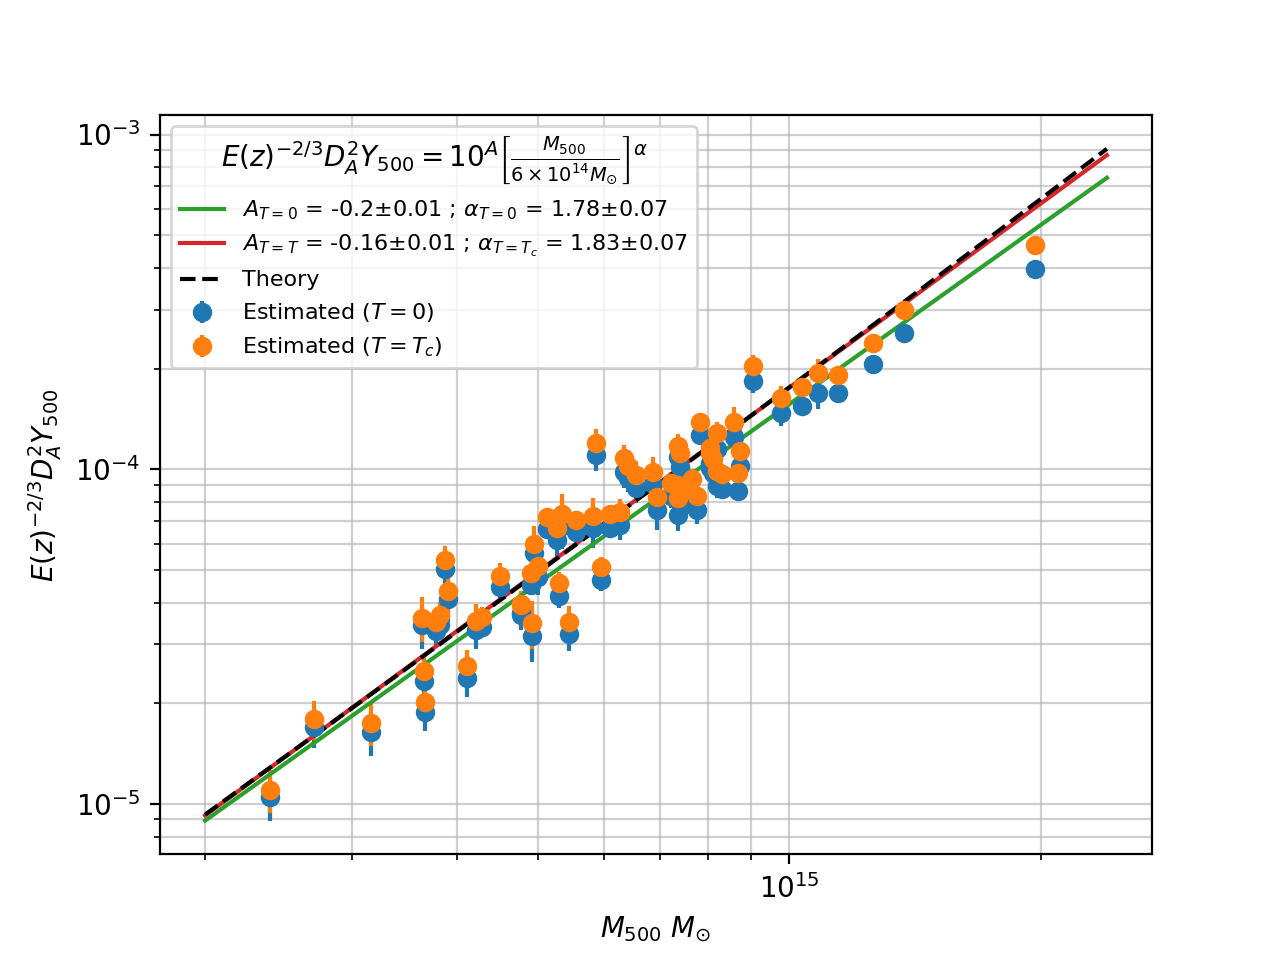

In [69]:
M500=linspace(2,24,1000)
T500=cosmo_fn.convert_M500_T500(M500,0.)
correction=1+0.07*(T500/5.)

norm=1e-4
figure()
errorbar(xsz_cat["M500"]*1e14,Ezgamma*fxsz_cat["YSZ_500"]*norm,yerr=fxsz_cat["YSZ_500_err"]*Ezgamma*norm,fmt="o",label="Estimated $(T=0)$")
errorbar(xsz_cat["M500"]*1e14,Ezgamma*fxsz_cat["YSZ_500_Tc"]*norm,yerr=fxsz_cat["YSZ_500_err_Tc"]*Ezgamma*norm,fmt="o",label="Estimated $(T=T_c)$")

lbl=r"$A_{T=0}$ = " + str(round(bT0[3],2)) + "$\pm$" + str(round(errbT0[3],2)) 
lbl=lbl + r" ; $\alpha_{T=0}$ = " +str(round(aT0[3],2))  + "$\pm$" + str(round(erraT0[3],2))
plot(M500*1e14,(10.**bT0[3])*((M500/6.)**aT0[3])*norm,label=lbl)

lbl=r"$A_{T=T}$ = " + str(round(bTT[3],2)) + r"$\pm$" + str(round(errbTT[3],2)) 
lbl=lbl + r" ; $\alpha_{T=T_c}$ = " +str(round(aTT[3],2))  + r"$\pm$" + str(round(erraTT[3],2))
plot(M500*1e14,(10.**bTT[3])*((M500/6.)**aTT[3])*norm,label=lbl)

plot(M500*1e14,(10.**bT0[3])*((M500/6.)**aT0[3])*norm*correction,"k--",label="Theory")

ylabel(r"$E(z)^{-2/3} D^2_A Y_{500}$")
xlabel(r"$M_{500}$" + " " + "$M_{\odot}$")
lbl=r"$E(z)^{-2/3} D^2_A Y_{500} = 10^A \left[ \frac{M_{500}}{6 \times 10^{14} M_{\odot}}\right]^\alpha$"
legend(loc=0,title=lbl,fontsize=8)
loglog()
grid(which="both",alpha=0.6)
figname=figpath + "Y500_vs_M500_rSZ_correction.pdf"
savefig(figname,bbox_inches="tight")

# Blind analysis

<IPython.core.display.Javascript object>


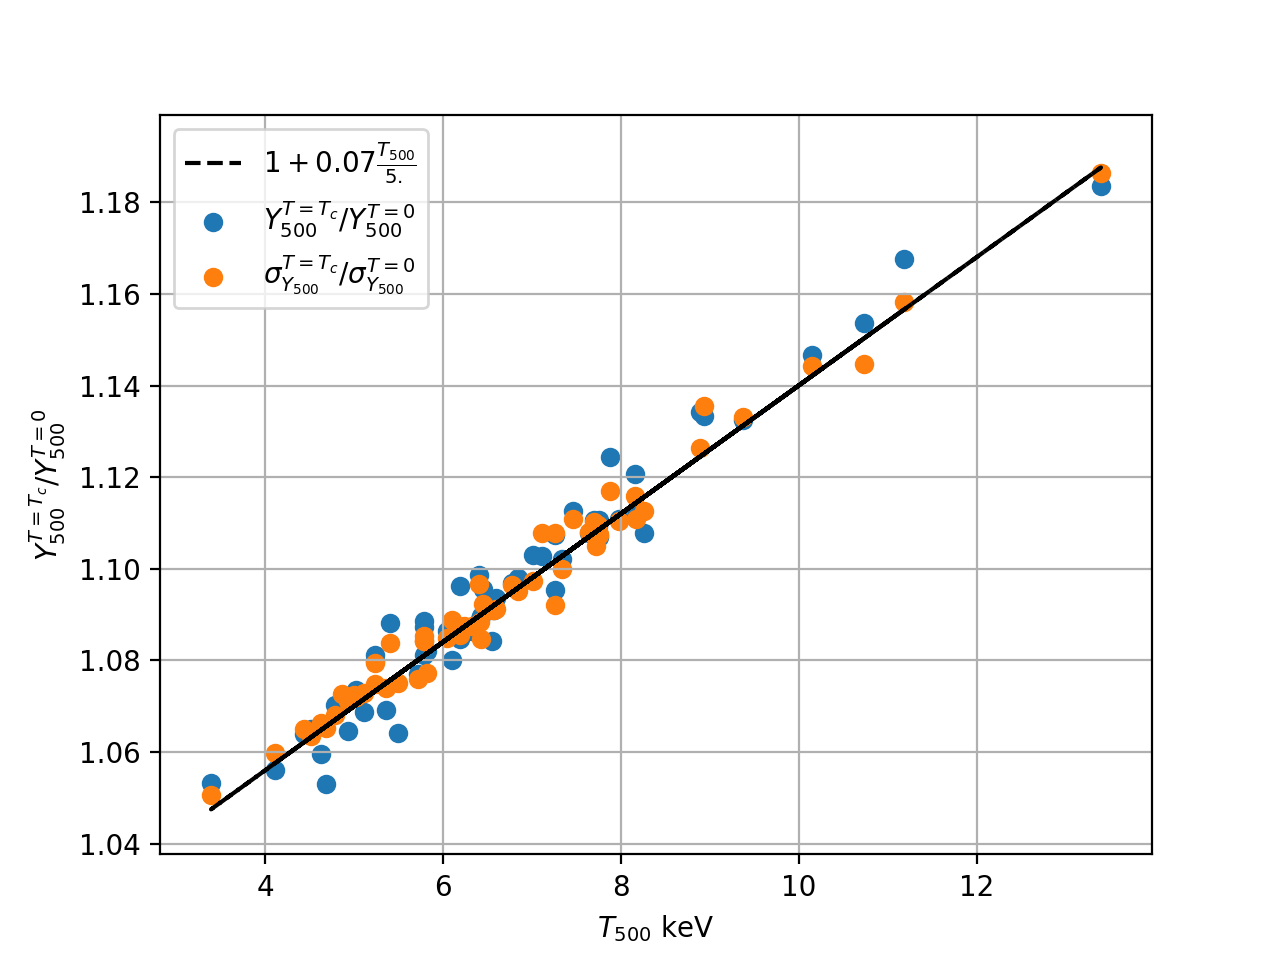

<IPython.core.display.Javascript object>


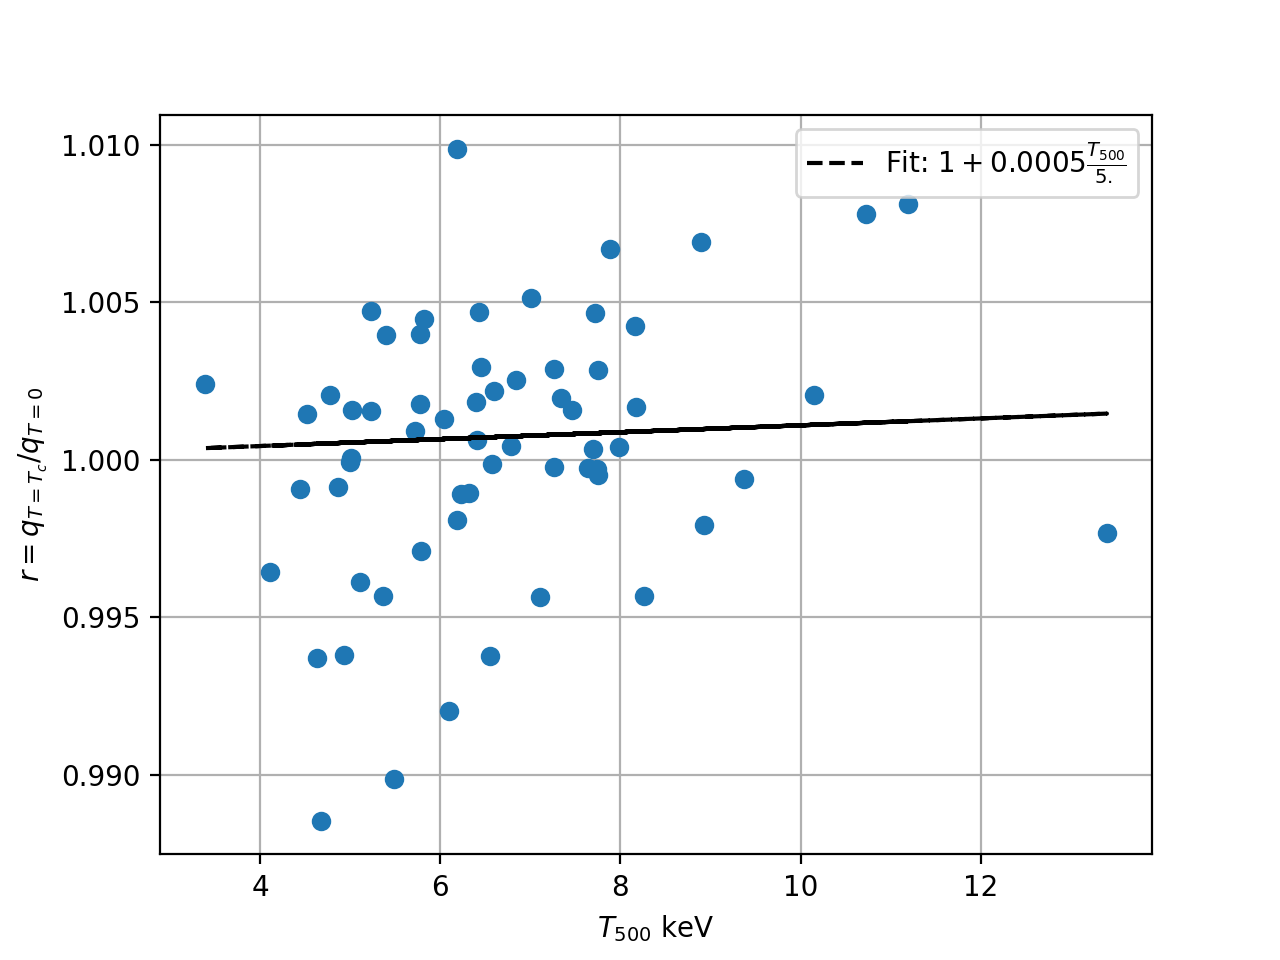

In [70]:
figure()
scatter(xsz_cat["T500"],bxsz_cat["YSZ_500_Tc"]/bxsz_cat["YSZ_500"],label="$Y^{T=T_c}_{500}/Y^{T=0}_{500}$")
scatter(xsz_cat["T500"],bxsz_cat["YSZ_500_err_Tc"]/bxsz_cat["YSZ_500_err"],label="$\sigma^{T=T_c}_{Y_{500}}/\sigma^{T=0}_{Y_{500}}$")
plot(xsz_cat["T500"],1+0.07*xsz_cat["T500"]/5.,"k--",label=r"$1 + 0.07 \frac{T_{500}}{5.}$")
xlabel('$T_{500}$ keV')
ylabel('$Y^{T=T_c}_{500}/Y^{T=0}_{500}$')
grid()
legend(loc=0)
figname=figpath + "Y500_T0_vs_Y500_Tc.pdf"
savefig(figname,bbox_inches="tight")



# Ratio of SNR
qTT=bxsz_cat["YSZ_500_Tc"]/bxsz_cat["YSZ_500_err_Tc"]
qT0=bxsz_cat["YSZ_500"]/bxsz_cat["YSZ_500_err"]

fn=lambda x,a: 1.+a*x/5.
slope,slope_err=curve_fit(fn,xsz_cat["T500"],qTT/qT0)

figure()
plot(xsz_cat["T500"],qTT/qT0,"o")
#plot(xsz_cat["T500"],1+0.07*xsz_cat["T500"]/5.,"r-",label=r"$1 + 0.07 \frac{T_{500}}{5.}$")
plot(xsz_cat["T500"],fn(xsz_cat["T500"],slope),"k--",label="Fit: " + "$1 + $" + str(round(slope,4)) + r"$\frac{T_{500}}{5.}$")
xlabel('$T_{500}$ keV')
ylabel('$r=q_{T=T_c}/q_{T=0}$')
grid()
legend(loc=0)
figname=figpath + "blind_SNR_qT0_qTT.pdf"

In [71]:
xdata=log10(xsz_cat["YX_500"]/1e-4)
xerr=return_log_err(xsz_cat["YX_500"]/1e-4,xsz_cat["YX_500_err"]/1e-4)

# Catalogue
ydata=log10(xsz_cat["YSZ_500"])
yerr=return_log_err(xsz_cat["YSZ_500"],xsz_cat["YSZ_500_err"])
acat,bcat,erracat,errbcat,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
print acat[3],erracat[3],bcat[3],errbcat[3]


# T=0
ydata=log10(bxsz_cat["YSZ_500"])
yerr=return_log_err(bxsz_cat["YSZ_500"],bxsz_cat["YSZ_500_err"])
aT0,bT0,erraT0,errbT0,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
print aT0[3],erraT0[3],bT0[3],errbT0[3]

# T=T_c
ydata=log10(bxsz_cat["YSZ_500_Tc"])
yerr=return_log_err(bxsz_cat["YSZ_500_Tc"],bxsz_cat["YSZ_500_err_Tc"])
aTT,bTT,erraTT,errbTT,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
print aTT[3],erraTT[3],bTT[3],errbTT[3]

BCES, 100000 trials... 
17.072106 s
0.958296476075 0.0400266840774 -4.02396970647 0.0123214893912
BCES, 100000 trials... 
16.125416 s
0.89619703238 0.0655218678927 -3.97882944285 0.0185625813662
BCES, 100000 trials... 
15.866640 s
0.925899433492 0.0666095994386 -3.93605112523 0.0185418221198


<IPython.core.display.Javascript object>


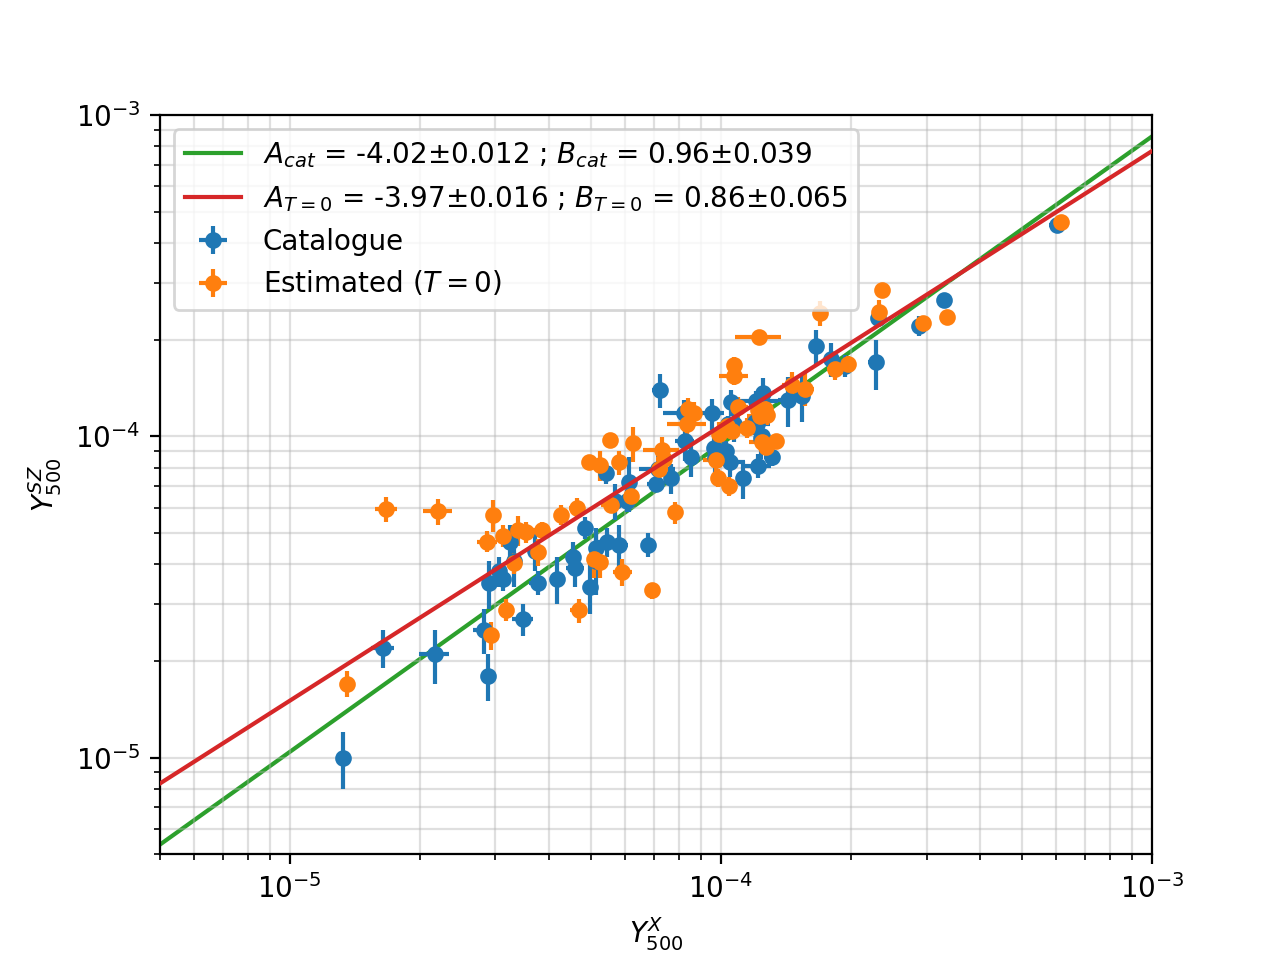

In [16]:
figure()
errorbar(xsz_cat["YX_500"],xsz_cat["YSZ_500"],xerr=xsz_cat["YX_500_err"],yerr=xsz_cat["YSZ_500_err"],fmt='o',ms=5,label="Catalogue")
errorbar(xsz_cat["YX_500"]+0.02*xsz_cat["YX_500"],bxsz_cat["YSZ_500"],xerr=xsz_cat["YX_500_err"],yerr=bxsz_cat["YSZ_500_err"],fmt='o',ms=5,label="Estimated $(T=0)$")
tempx=linspace(5e-6,5e-3,1000)
lbl="$A_{cat}$ = " + str(round(bcat[3],2)) + "$\pm$" + str(round(errbcat[3],3)) 
lbl=lbl + " ; $B_{cat}$ = " +str(round(acat[3],2))  + "$\pm$" + str(round(erracat[3],3))
plot(tempx,(10.**bcat[3])*(tempx/1e-4)**acat[3],label=lbl,zorder=1)

lbl="$A_{T=0}$ = " + str(round(bT0[3],2)) + "$\pm$" + str(round(errbT0[3],3)) 
lbl=lbl + " ; $B_{T=0}$ = " +str(round(aT0[3],2))  + "$\pm$" + str(round(erraT0[3],3))
plot(tempx,(10.**bT0[3])*(tempx/1e-4)**aT0[3],label=lbl,zorder=3)
ylim(5e-6,1e-3)
xlim(5e-6,1e-3)
loglog()
legend(loc=0)
ylabel("$Y^{SZ}_{500}$",fontsize=10)
xlabel("$Y^X_{500}$",fontsize=10)
grid(which="both",alpha=0.4)
figname=figpath + "blind_YSZ500_YX500_cat_vs_est.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


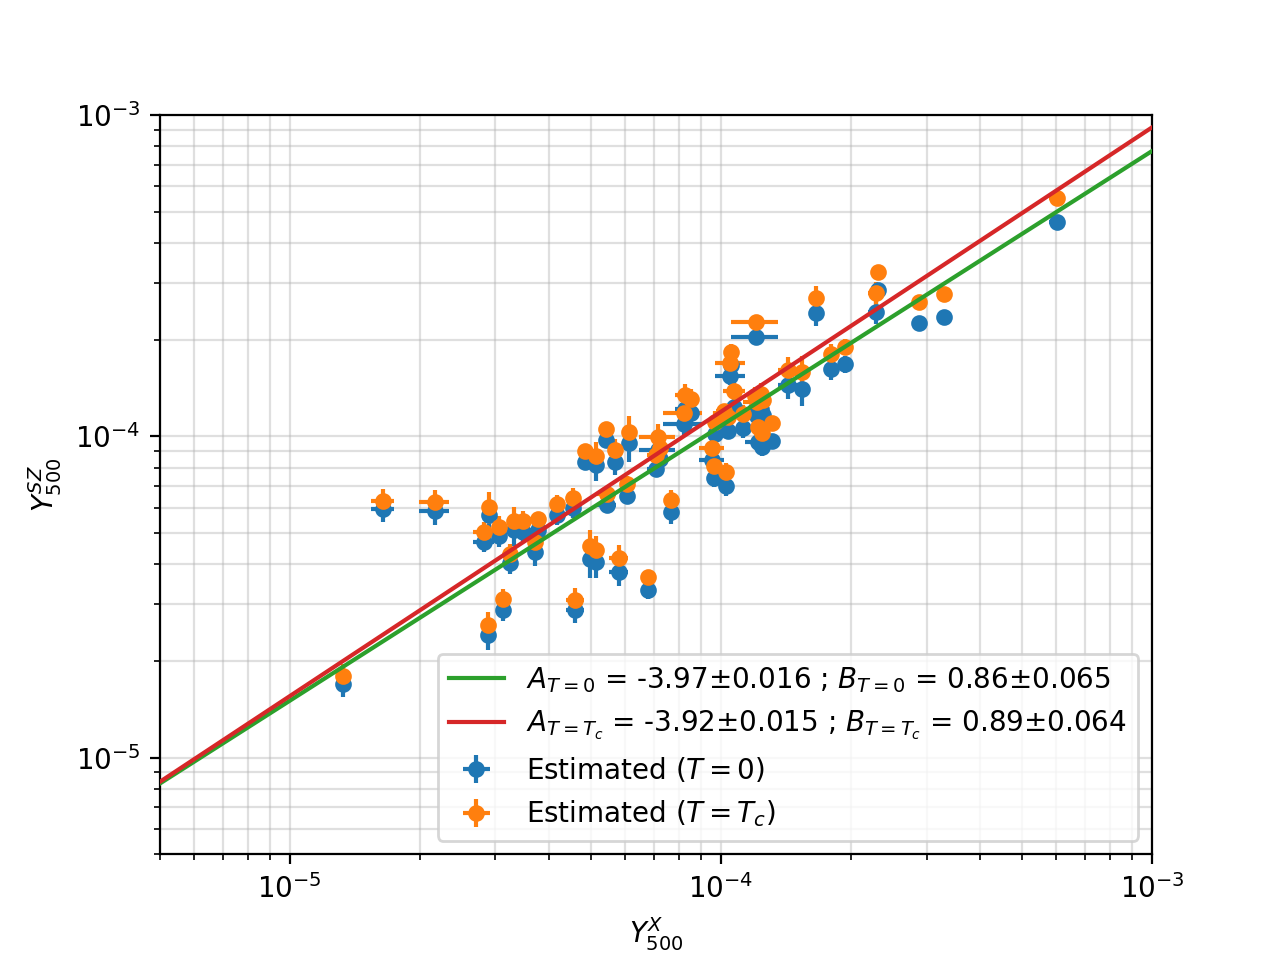

In [17]:
figure()
errorbar(xsz_cat["YX_500"],bxsz_cat["YSZ_500"],xerr=xsz_cat["YX_500_err"],yerr=bxsz_cat["YSZ_500_err"],fmt='o',ms=5,label="Estimated $(T=0)$")
errorbar(xsz_cat["YX_500"],bxsz_cat["YSZ_500_Tc"],xerr=xsz_cat["YX_500_err"],yerr=bxsz_cat["YSZ_500_err_Tc"],fmt='o',ms=5,label="Estimated $(T=T_c)$")
tempx=linspace(5e-6,5e-3,1000)
lbl="$A_{T=0}$ = " + str(round(bT0[3],2)) + "$\pm$" + str(round(errbT0[3],3)) 
lbl=lbl + " ; $B_{T=0}$ = " +str(round(aT0[3],2))  + "$\pm$" + str(round(erraT0[3],3))
plot(tempx,(10.**bT0[3])*(tempx/1e-4)**aT0[3],label=lbl,zorder=3)

lbl="$A_{T=T_c}$ = " + str(round(bTT[3],2)) + "$\pm$" + str(round(errbTT[3],3)) 
lbl=lbl + " ; $B_{T=T_c}$ = " +str(round(aTT[3],2))  + "$\pm$" + str(round(erraTT[3],3))
plot(tempx,(10.**bTT[3])*(tempx/1e-4)**aTT[3],label=lbl,zorder=5)

ylim(5e-6,1e-3)
xlim(5e-6,1e-3)
loglog()
legend(loc=0)
ylabel("$Y^{SZ}_{500}$",fontsize=10)
xlabel("$Y^X_{500}$",fontsize=10)
grid(which="both",alpha=0.4)
figname=figpath + "blind_YSZ500_YX500_T0_vs_TT.pdf"
savefig(figname,bbox_inches="tight")

In [18]:
# # This produces numbers in row 2 of Table 2 from Planck early results XI (A&A 536 A11 2011)
# Ezgamma=cosmo_fn.Ez(xsz_cat["z"])**(-2./3.)
# This produces numbers in Table A.1 from Planck Collaboration: Cosmology from SZ cluster counts (2013)
Ezgamma=cosmo_fn.Ez(xsz_cat["z"])**(-2./3.)/1e-4

xdata=log10(xsz_cat["M500"]/6.)
xerr=return_log_err(xsz_cat["M500"]/6.,xsz_cat["M500_err"]/6.)

# Catalogue
ydata=log10(xsz_cat["YSZ_500"]*Ezgamma)
yerr=return_log_err(xsz_cat["YSZ_500"]*Ezgamma,xsz_cat["YSZ_500_err"]*Ezgamma)
acat,bcat,erracat,errbcat,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
print acat[3],erracat[3],bcat[3],errbcat[3]


# T=0
ydata=log10(bxsz_cat["YSZ_500"]*Ezgamma)
yerr=return_log_err(bxsz_cat["YSZ_500"]*Ezgamma,bxsz_cat["YSZ_500_err"]*Ezgamma)
aT0,bT0,erraT0,errbT0,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
print aT0[3],erraT0[3],bT0[3],errbT0[3]

# T=T_c
ydata=log10(bxsz_cat["YSZ_500_Tc"]*Ezgamma)
yerr=return_log_err(bxsz_cat["YSZ_500_Tc"]*Ezgamma,bxsz_cat["YSZ_500_err_Tc"]*Ezgamma)

aTT,bTT,erraTT,errbTT,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
print aTT[3],erraTT[3],bTT[3],errbTT[3]

BCES, 100000 trials... 
13.447056 s
1.73448193607 0.0759463314093 -0.188380612466 0.0126430867638
BCES, 100000 trials... 
14.977832 s
1.64303621702 0.128606684713 -0.11754119817 0.0192486384294
BCES, 100000 trials... 
15.770919 s
1.69069279062 0.126071927653 -0.0778011778671 0.0192148761461


<IPython.core.display.Javascript object>


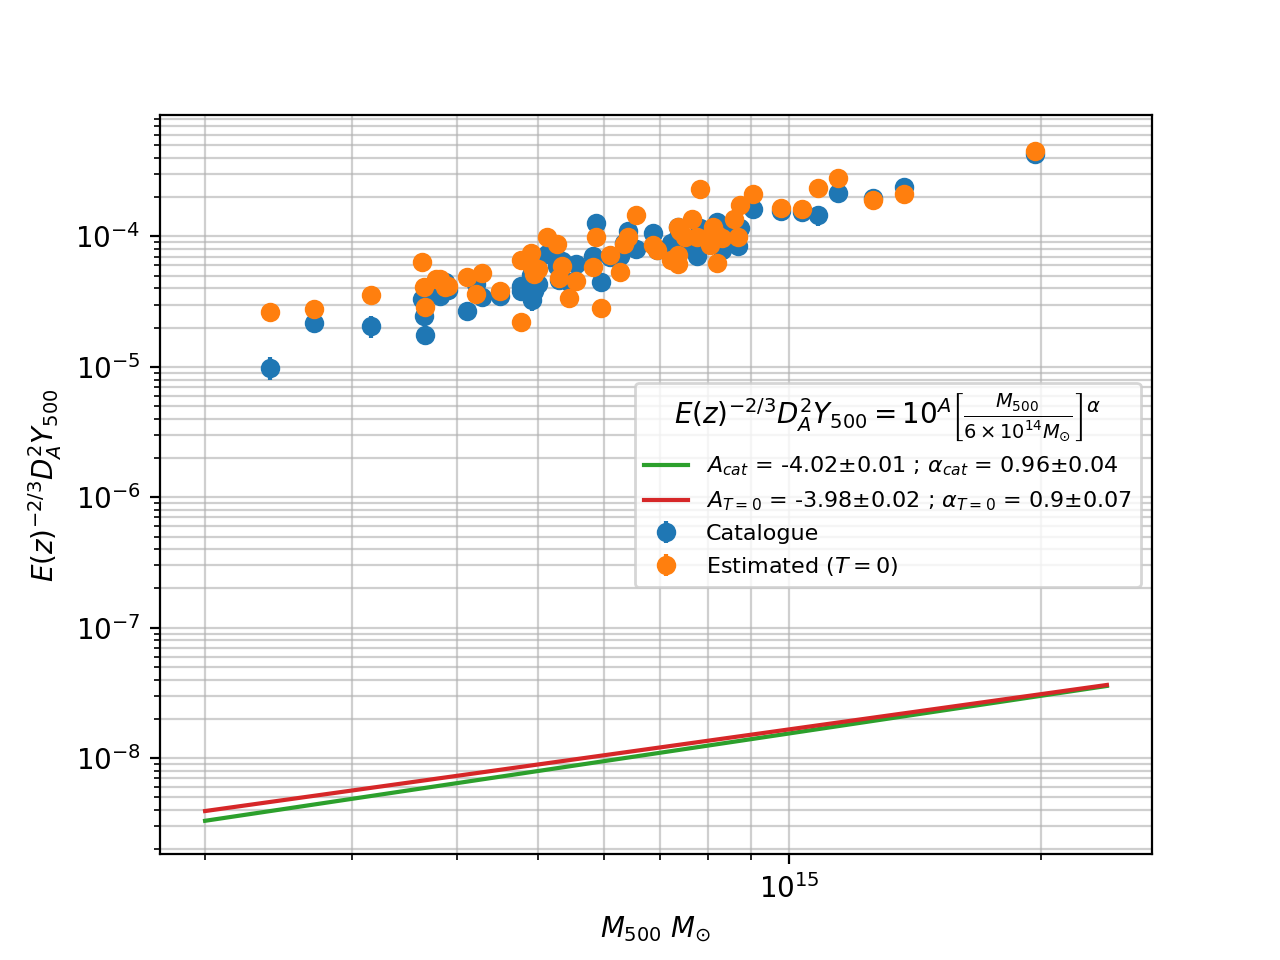

In [72]:
M500=linspace(2,24,1000)
norm=1e-4
figure()
errorbar(xsz_cat["M500"]*1e14,Ezgamma*xsz_cat["YSZ_500"]*norm,yerr=xsz_cat["YSZ_500_err"]*Ezgamma*norm,fmt="o",label="Catalogue")
errorbar(xsz_cat["M500"]*1e14,Ezgamma*bxsz_cat["YSZ_500"]*norm,yerr=bxsz_cat["YSZ_500_err"]*Ezgamma*norm,fmt="o",label="Estimated $(T=0)$")

lbl=r"$A_{cat}$ = " + str(round(bcat[3],2)) + r"$\pm$" + str(round(errbcat[3],2)) 
lbl=lbl + r" ; $\alpha_{cat}$ = " +str(round(acat[3],2))  + r"$\pm$" + str(round(erracat[3],2))
plot(M500*1e14,(10.**bcat[3])*((M500/6.)**acat[3])*norm,label=lbl)

lbl=r"$A_{T=0}$ = " + str(round(bT0[3],2)) + "$\pm$" + str(round(errbT0[3],2)) 
lbl=lbl + r" ; $\alpha_{T=0}$ = " +str(round(aT0[3],2))  + "$\pm$" + str(round(erraT0[3],2))
plot(M500*1e14,(10.**bT0[3])*((M500/6.)**aT0[3])*norm,label=lbl)

ylabel(r"$E(z)^{-2/3} D^2_A Y_{500}$")
xlabel(r"$M_{500}$" + " " + "$M_{\odot}$")
lbl=r"$E(z)^{-2/3} D^2_A Y_{500} = 10^A \left[ \frac{M_{500}}{6 \times 10^{14} M_{\odot}}\right]^\alpha$"
legend(loc=0,title=lbl,fontsize=8)
loglog()
grid(which="both",alpha=0.6)
figname=figpath + "blind_Y500_vs_M500_compare_with_cat.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


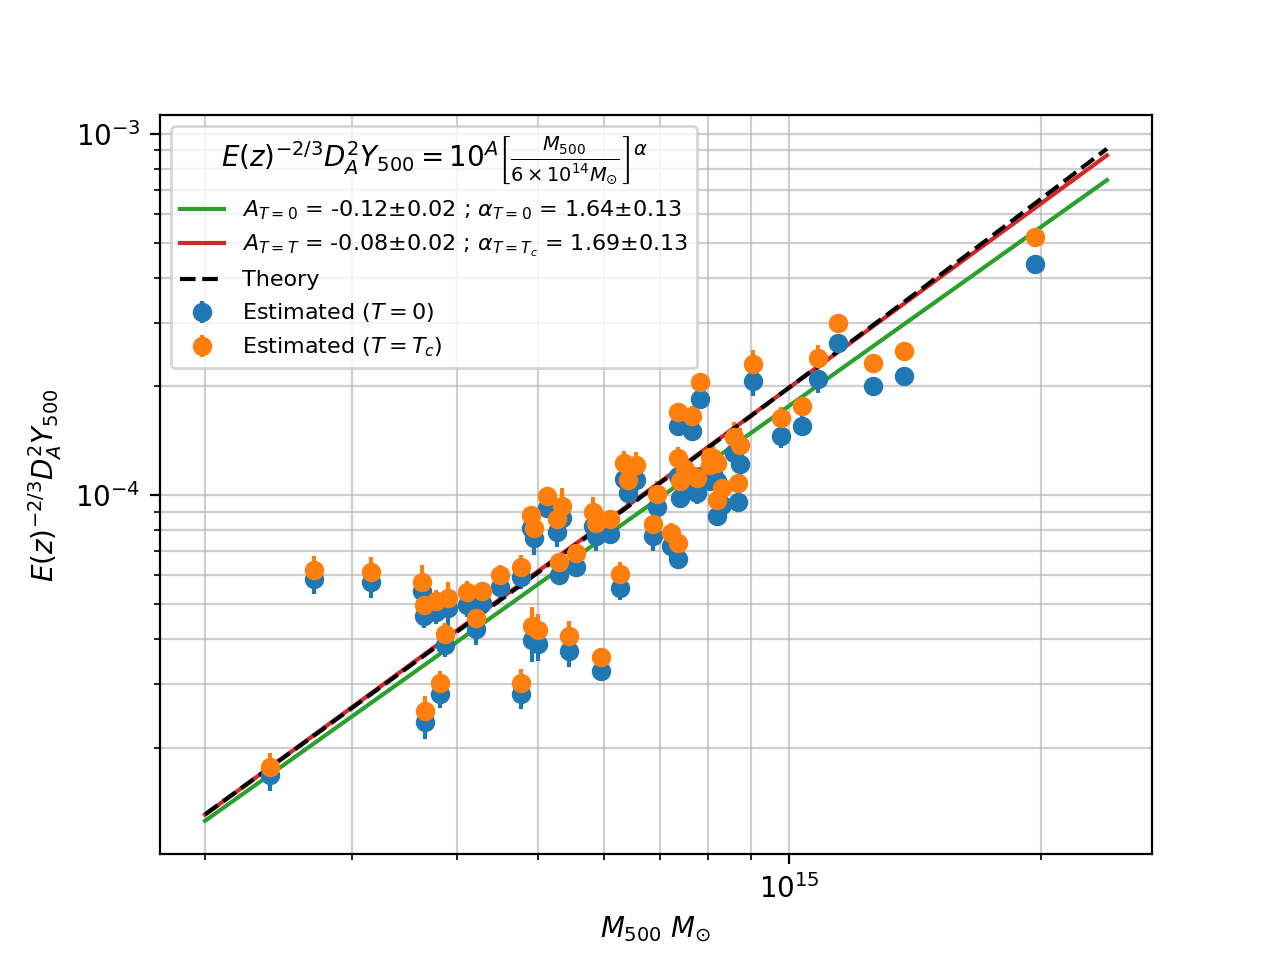

In [20]:
M500=linspace(2,24,1000)
T500=cosmo_fn.convert_M500_T500(M500,0.)
correction=1+0.07*(T500/5.)

norm=1e-4
figure()
errorbar(xsz_cat["M500"]*1e14,Ezgamma*bxsz_cat["YSZ_500"]*norm,yerr=bxsz_cat["YSZ_500_err"]*Ezgamma*norm,fmt="o",label="Estimated $(T=0)$")
errorbar(xsz_cat["M500"]*1e14,Ezgamma*bxsz_cat["YSZ_500_Tc"]*norm,yerr=bxsz_cat["YSZ_500_err_Tc"]*Ezgamma*norm,fmt="o",label="Estimated $(T=T_c)$")

lbl=r"$A_{T=0}$ = " + str(round(bT0[3],2)) + "$\pm$" + str(round(errbT0[3],2)) 
lbl=lbl + r" ; $\alpha_{T=0}$ = " +str(round(aT0[3],2))  + "$\pm$" + str(round(erraT0[3],2))
plot(M500*1e14,(10.**bT0[3])*((M500/6.)**aT0[3])*norm,label=lbl)

lbl=r"$A_{T=T}$ = " + str(round(bTT[3],2)) + r"$\pm$" + str(round(errbTT[3],2)) 
lbl=lbl + r" ; $\alpha_{T=T_c}$ = " +str(round(aTT[3],2))  + r"$\pm$" + str(round(erraTT[3],2))
plot(M500*1e14,(10.**bTT[3])*((M500/6.)**aTT[3])*norm,label=lbl)

plot(M500*1e14,(10.**bT0[3])*((M500/6.)**aT0[3])*norm*correction,"k--",label="Theory")

ylabel(r"$E(z)^{-2/3} D^2_A Y_{500}$")
xlabel(r"$M_{500}$" + " " + "$M_{\odot}$")
lbl=r"$E(z)^{-2/3} D^2_A Y_{500} = 10^A \left[ \frac{M_{500}}{6 \times 10^{14} M_{\odot}}\right]^\alpha$"
legend(loc=0,title=lbl,fontsize=8)
loglog()
grid(which="both",alpha=0.6)
figname=figpath + "blind_Y500_vs_M500_rSZ_correction.pdf"
savefig(figname,bbox_inches="tight")